In [1]:
%cd ..

/home/oleg


In [8]:
# type: ignore

import typing
from typing import Any, cast
from dataclasses import dataclass

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm.auto import tqdm

from asr_eval.data import Recording
from asr_eval.align.data import Token
from asr_eval.models.gigaam import EncodeError
from asr_eval.streaming.sender import StreamingAudioSender, BaseStreamingAudioSender
from asr_eval.streaming.caller import receive_full_transcription
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import TranscriptionChunk, InputChunk, OutputChunk
from asr_eval.streaming.evaluation import RecordingStreamingEvaluation, PartialAlignment, get_partial_alignments, remap_time
from asr_eval.streaming.plots import partial_alignment_diagram, visualize_history
from asr_eval.streaming.timings import get_word_timings

In [2]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [3]:
# type: ignore

name, split = 'bond005/podlodka_speech', 'test'
dataset: Dataset = (
    load_dataset(name)[split]
    .cast_column("audio", Audio(sampling_rate=16_000))
)

samples: list[Recording] = []

for i in tqdm(range(len(dataset))):
    try:
        samples.append(Recording.from_sample(
            sample=dataset[i],
            name=name,
            split=split,
            index=i,
            use_gigaam=gigaam_model,
        ))
    except EncodeError:
        pass

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
for sample in samples:
    sample.evals = RecordingStreamingEvaluation()
    sample.evals.id = sample.hf_uid
    sample.evals.sender = StreamingAudioSender(
        id=sample.evals.id,
        audio=np.int16(sample.waveform * 32768).tobytes(),
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        verbose=False,
    )

In [6]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()

for sample in samples:
    sample.evals.output_chunks = receive_full_transcription(
        asr=asr,
        sender=sample.evals.sender,
        id=sample.evals.id,
        send_all_without_delays=True,
    )

asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

Transcribing bond005/podlodka_speech/test/0
Transcribed bond005/podlodka_speech/test/0: и поэтому использовать их в повседневности не получается мы вынуждены отступать
Transcribing bond005/podlodka_speech/test/3
Transcribed bond005/podlodka_speech/test/3: да это отсутствие долго живущие бранчей другими словами отсутствие какому- [...]
Transcribing bond005/podlodka_speech/test/4
Transcribed bond005/podlodka_speech/test/4: то есть мы в каждый момент времени знаем про звук ещё и какое-то такое [...]
Transcribing bond005/podlodka_speech/test/5
Transcribed bond005/podlodka_speech/test/5: и мне кажется абсолютно все замечали что детские крики раздражают там и ты [...]
Transcribing bond005/podlodka_speech/test/6
Transcribed bond005/podlodka_speech/test/6: неужто не может быть какое-то количество дискретных столбиков где каждый [...]
Transcribing bond005/podlodka_speech/test/7
Transcribed bond005/podlodka_speech/test/7: второй челлендж он чисто поисковая это собственно как делать этот поиск [.

In [7]:
for sample in samples:
    assert sample.evals is not None
    assert sample.evals.sender is not None
    assert sample.evals.output_chunks is not None
    sample.evals.input_chunks_remapped, sample.evals.output_chunks_remapped = remap_time(
        sample.evals.sender.get_send_times(), sample.evals.sender.history, sample.evals.output_chunks
    )

In [10]:
for sample in tqdm(samples):
    assert sample.evals is not None
    assert sample.evals.input_chunks_remapped is not None
    assert sample.evals.output_chunks_remapped is not None
    sample.evals.partial_alignments = get_partial_alignments(
        sample.evals.input_chunks_remapped,
        sample.evals.output_chunks_remapped,
        cast(list[Token], sample.transcription_words),
        processes=1,
    )

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
for sample in samples:
    assert sample.evals is not None
    assert sample.evals.sender is not None
    assert sample.evals.partial_alignments is not None
    partial_alignment_diagram(
        sample.evals.partial_alignments,
        cast(list[Token], sample.transcription_words),
        audio_len=cast(float, sample.evals.sender.history[-1].end_time),  # TODO: may be not precise
        figsize=(12, 2),
        y_type='processed',
    )

In [38]:
from typing import Literal

from asr_eval.align.data import Match, Token

stats: list[tuple[float, Literal['correct', 'error', 'not_yet']]] = []

def get_center_time(token: Token):
    return (token.start_time + token.end_time) / 2

# TODO find a better way
partial_alignments[-1].audio_seconds_processed = partial_alignments[-2].audio_seconds_processed

for partial_alignment in partial_alignments:
    # split into head and tail
    head: list[Match] = []
    tail: list[Match] = []
    in_tail = True
    for match in partial_alignment.alignment.matches[::-1]:
        in_tail &= match.status == 'deletion'
        if in_tail:
            tail.insert(0, match)
        else:
            head.insert(0, match)
            
    sec_processed = cast(float, partial_alignment.audio_seconds_processed)
    
    # process head
    for i, match in enumerate(head):
        if match.status == 'correct':
            for token in match.true:
                stats.append((sec_processed - get_center_time(token), 'correct'))
        elif match.status == 'insertion':
            left_pos = max(
                [0] + [token.end_time for match2 in head[:i] for token in match2.true]
            )
            right_pos = min(
                [sec_processed] + [token.end_time for match2 in head[i + 1:] for token in match2.true]
            )
            stats.append((sec_processed - (left_pos + right_pos) / 2, 'error'))
        else:
            for token in match.true:
                stats.append((sec_processed - get_center_time(token), 'error'))
    
    # process tail
    for match in tail:
        for token in match.true:
            stats.append((sec_processed - get_center_time(token), 'not_yet'))


counts: dict[Literal['correct', 'error', 'not_yet'], npt.NDArray[np.int64]] = {}

bins = [0, 1, 2, 3, 5, 10, 1000]
for status in 'correct', 'error', 'not_yet':
    counts[status] = np.histogram([t for t, s in stats if s == status], bins=bins)[0]

total_counts = sum(counts.values())

ratios = {status: c / total_counts for status, c in counts.items()}
ratios

{'correct': array([0.        , 0.24074074, 0.66666667, 0.74725275, 0.81065089,
        0.79775281]),
 'error': array([0.        , 0.18518519, 0.31372549, 0.25274725, 0.18934911,
        0.20224719]),
 'not_yet': array([1.        , 0.57407407, 0.01960784, 0.        , 0.        ,
        0.        ])}

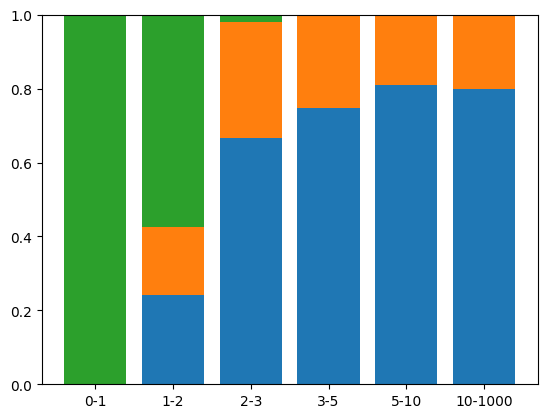

In [ ]:
from itertools import pairwise
import matplotlib.pyplot as plt

xrange = range(len(bins) - 1)
plt.bar(xrange, height=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['error'], bottom=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['not_yet'], bottom=ratios['correct'] + ratios['error']) # type: ignore
plt.gca().set_xticks(xrange) # type: ignore
plt.gca().set_xticklabels([f'{a}-{b}' for a, b in pairwise(bins)]) # type: ignore
plt.show() # type: ignore

In [17]:
# print('Final transcription:', TranscriptionChunk.join(output_chunks))

# true_token_id_to_time_span = {
#     token.id: (start, end) for token, start, end in word_timings
# }

# last_word_end = [
#     max([
#         true_token_id_to_time_span[m.true[-1].id][-1]
#         for m in partial_al.alignment.matches
#         if m.status not in ('deletion', 'insertion')
#     ] or [0])
#     for partial_al in partial_alignments
# ]

# latency_sent = [p.audio_seconds_sent - end for p, end in zip(partial_alignments, last_word_end)]
# print(f'Average latency (sent): {np.mean(latency_sent):.1f} sec')

# latency_processed = [p.audio_seconds_processed - end for p, end in zip(partial_alignments, last_word_end)] # type: ignore
# print(f'Average latency (processed): {np.mean(latency_processed):.1f} sec') # type: ignore